Als Vorverarbeitung wollen wir die folgenden winkelerhaltenden Strategien zur Distanzminimierung untersuchen. 

Dazu skalieren wir alle Kreise so, dass
   - ihre Größe maximal wird, ohne dass dabei irgendwo ein Overlap entsteht 
   - der kleinste Abstand 0 wird, ohne Beachtung von Überlappung anderer Knoten (-> Skalierung um Faktor der kleinsten relative Distanz)
   - ihr durchschnittlicher relativer Abstand 0 würde, wenn man negative Abstände einbeziehen würde (-> Skalierung um Faktor der mittleren Distanz)
   - das p-Quantil der relativen Distanzen 0 wird.

In [23]:
import numpy as np
import pandas as pd
import itertools
from utils import input
from utils import score
from utils import optimize

In [9]:
input_file, output_file = input.get_highest_score_file("Population_Density_Afro-Eurasia")


input_nodes, edges_df, k = input.read_to_df(input_file)
#input_nodes['radius'] = np.sqrt(input_nodes.value)
output_nodes = score.read_to_df(output_file)

edges = list(zip(edges_df.node_0.to_list(), edges_df.node_1.to_list()))
n, start_overlap, start_distance, start_angle, start_score = score.calc_score(input_nodes, output_nodes, edges, k)
print(f"Score: {start_score:.2f} (n={n}, k={k}, overlap={start_overlap:.2f}, distance={start_distance:.2f}, angle={start_angle:.2f})\n")

Score: 5192.05 (n=133, k=554, overlap=9.89, distance=43.47, angle=23.26)


In [10]:
edges_df['R'] = edges_df.apply(lambda x: output_nodes.at[x.node_0, 'radius'] + output_nodes.at[x.node_1, 'radius'], axis=1)
edges_df['target_angle'] = edges_df.apply(lambda x: score.calc_angle(input_nodes, x.node_0, x.node_1), axis=1)

edges_df['angle'] = edges_df.apply(lambda x: score.calc_angle(output_nodes, x.node_0, x.node_1), axis=1)
edges_df['length'] = edges_df.apply(lambda x: 
                                    np.hypot(output_nodes.at[x.node_0, 'x'] - output_nodes.at[x.node_1, 'x'], output_nodes.at[x.node_0, 'y'] - output_nodes.at[x.node_1, 'y']),
                                    axis=1)

edges_df['angle_diff'] = edges_df.apply(lambda x: 
                                        min(abs(x.target_angle - x.angle), 2 - abs(x.target_angle - x.angle)) * 100,
                                        axis=1)
edges_df['distance'] = (edges_df['length'] / edges_df['R']) * 100 - 100
edges_df.loc[edges_df['distance'] < 0, 'distance'] = 0

edges_df

,node_0,node_1,target_angle,R,angle,length,angle_diff,distance
0,AND,FRA,-0.536221,1.610428,-0.828719,1.707745,29.249797,6.042887
1,AND,ESP,0.133652,1.534784,0.691070,1.534776,55.741843,0.000000
2,ARE,OMN,0.750000,1.040029,0.057703,1.065406,69.229683,2.440015
3,ARE,SAU,-0.035223,1.058530,-0.091753,1.019576,5.652992,0.000000
4,AFG,CHN,-0.984098,1.369057,-0.786412,1.362178,19.768569,0.000000
...,...,...,...,...,...,...,...,...
272,TKM,UZB,-0.922021,0.851041,-0.277531,1.189815,64.449008,39.807018
273,TZA,UGA,-0.371119,1.634983,-0.550253,2.426562,17.913402,48.415085
274,TZA,ZMB,0.338586,0.941803,0.324900,0.858353,1.368531,0.000000
275,ZAF,ZWE,-0.687167,0.916588,-0.451763,0.825944,23.540370,0.000000


In [11]:
edges_df.describe()

,target_angle,R,angle,length,angle_diff,distance
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,-0.019997,1.373207,0.005391,1.886008,23.263279,43.467327
std,0.598705,1.041102,0.573869,1.529756,17.152196,61.140805
min,-0.995699,0.245774,-0.995697,0.240852,0.029208,0.000000
25%,-0.535223,0.883176,-0.490033,1.032928,10.551756,0.000000
50%,0.000000,1.203199,-0.054636,1.426043,20.059980,8.060730
75%,0.500000,1.517396,0.520049,2.227798,32.678068,68.947668
max,1.000000,10.673078,0.980137,11.762671,79.037608,425.272696


In [12]:
overlaps = [(node_a, node_b, score.calc_overlap(output_nodes, node_a, node_b)) for node_a, node_b in itertools.combinations(output_nodes.index, 2)]

In [19]:
overlaps = sorted([a for a in overlaps if a[2] > 0], key=lambda x: x[2], reverse=True)
overlaps

[('HUN', 'MNE', 0.09893603576381554),
 ('BIH', 'SVK', 0.09893570792392962),
 ('PRT', 'FRA', 0.09893498745943959),
 ('AZE', 'TJK', 0.09893395534196762),
 ('GIN', 'CIV', 0.09893394618504224),
 ('MMR', 'LAO', 0.09893389701788137),
 ('GNQ', 'GAB', 0.09893241478713215),
 ('BFA', 'BEN', 0.09893227466562193),
 ('EGY', 'PSE', 0.09893202310391642),
 ('BRN', 'HKG', 0.09893198924984432),
 ('TUN', 'EGY', 0.09893192957491195),
 ('SRB', 'HUN', 0.09893187612502366),
 ('SAU', 'OMN', 0.09893175947216214),
 ('LBN', 'PSE', 0.09893162508531998),
 ('SYR', 'PSE', 0.09893088647726724),
 ('YEM', 'OMN', 0.09893083226123954),
 ('LIE', 'AUT', 0.09893018162683405),
 ('GHA', 'BEN', 0.09892955753480935),
 ('RWA', 'MWI', 0.09892861782650639),
 ('ZAF', 'SWZ', 0.09892835741134619),
 ('ZWE', 'BWA', 0.09892737619284502),
 ('NGA', 'MLI', 0.09892712735977967),
 ('SLE', 'CIV', 0.09892642469989087),
 ('KEN', 'SOM', 0.098925971880092),
 ('SDN', 'SSD', 0.09892585109990033),
 ('SVK', 'MDA', 0.09892564792174936),
 ('MMR', 'IND'

In [20]:
o = overlaps[0][2] * 100
d = edges_df.distance.mean()
a = edges_df.angle_diff.mean()
def score_plot(n, k, o, d, a):
    return 1000. * (n + k) / (1 + 0.1 * (o ** 2) + 0.05 * (d ** 2) + 0.05 * (a ** 2))
score_plot(n, k, o, d, a)

5192.046308525974

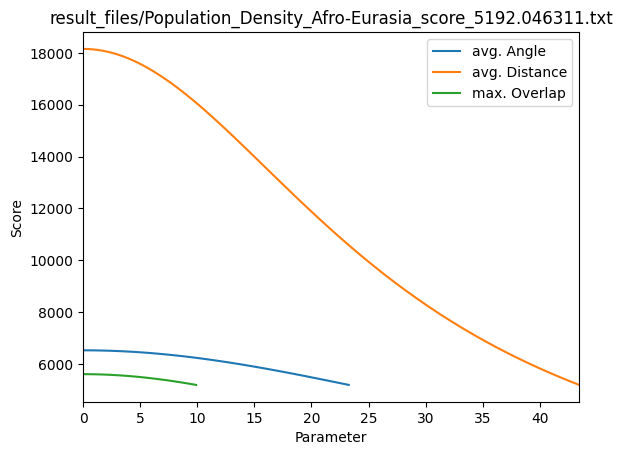

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, a, 100), score_plot(n, k, o, d, np.linspace(0, a, 100)), label="avg. Angle")
plt.plot(np.linspace(0, d, 100), score_plot(n, k, o, np.linspace(0, d, 100), a), label="avg. Distance")
plt.plot(np.linspace(0, o, 100), score_plot(n, k, np.linspace(0, o, 100), d, a), label="max. Overlap")
plt.title(output_file)
plt.ylabel("Score")
plt.xlabel("Parameter")
plt.xlim(0, max(o, d, a))
plt.legend()
plt.show()

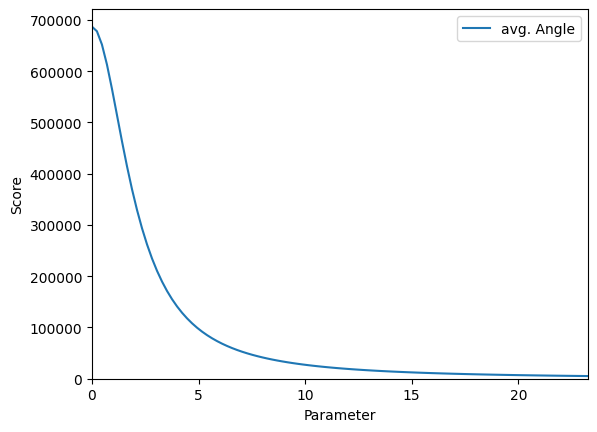

In [22]:
plt.plot(np.linspace(0, a, 100), score_plot(n, k, np.linspace(0, o, 100), np.linspace(0, d, 100), np.linspace(0, a, 100)), label="avg. Angle")
plt.ylabel("Score")
plt.xlabel("Parameter")
plt.xlim(0, a)
plt.ylim(0)
plt.legend()
plt.show()

In [26]:
adj_list = optimize.get_adj(output_nodes, edges_df)
single_edge_nodes = optimize.get_nodes_with_single_edge(adj_list)

In [27]:
edges_df.loc[edges_df.node_0.isin(single_edge_nodes) | edges_df.node_1.isin(single_edge_nodes)]

,node_0,node_1,target_angle,R,angle,length,angle_diff,distance
59,BRN,MYS,0.234854,1.311339,0.231323,1.196399,0.353105,0.000000
96,CHN,HKG,0.698371,6.512166,0.880065,10.995853,18.169489,68.850933
102,CHN,MAC,0.686592,10.673078,-0.660866,11.762671,65.254122,10.208798
113,DEU,DNK,-0.562833,1.857384,-0.809121,1.673773,24.628803,0.000000
139,ESP,GIB,0.387640,5.322187,0.237329,8.125788,15.031092,52.677595
141,ESP,PRT,0.039583,1.368172,-0.750673,1.232885,79.025659,0.000000
151,FRA,MCO,0.871831,9.797975,-0.337793,10.675448,79.037608,8.955652
156,GMB,SEN,-0.939525,1.760740,0.909844,1.684481,15.063143,0.000000
175,IDN,PNG,0.988216,1.139284,0.654949,1.026586,33.326686,0.000000
176,IDN,TLS,0.815519,1.461873,0.859313,1.436964,4.379423,0.000000
